In [215]:
import json
import networkx as nx
from typing import List

with open("openbb_functions_enum.json", "r") as f:
    openbb_functions = json.load(f)
with open("reference.json", "r") as f:
    data = json.load(f)
openbb_functions_name_dict = {k['name']:k for k in openbb_functions}

routers_names = [r.split("/")[1] for r in data['routers']]
router_specific_paths = {k:[] for k in routers_names}
for paths in data['paths']:
    req_router = paths.split("/")[1]
    router_specific_paths[req_router].append(paths)    
def get_graph(G,router_name:str,router_specific_paths_names:List[str]):
    desc = data['routers']['/'+router_name]
    if G is None:
        G = nx.DiGraph()
    # G.add_edge("openbb",router_name)
    G.add_nodes_from([(router_name,{"type":"first_level_node","description":desc['description']})])
    for router_paths in router_specific_paths_names:
        if data['paths'][router_paths]['deprecated']['flag']: continue
        router_path_split = router_paths.split("/")[1:]
        func_name = router_paths.split("/")[1:]
        func_name = "obb_" + "_".join(func_name)
        trail = ""
        if len(router_path_split)>2:
            if not G.has_node(router_path_split[1]):
                trail += f"{router_name}"
                G.add_nodes_from([(router_path_split[1],{"type":"second_level_node","trail":f"{trail}"})])
                G.add_edge(router_name,router_path_split[1])
            if func_name not in openbb_functions_name_dict:
                provider_parameters = data['paths'][router_paths]['parameters']['standard']
                for pp in provider_parameters:
                    if pp['name'] == 'provider':
                        real_provider = pp['type'][pp['type'].find("[")+2:pp['type'].find("]")-1]
                        func_name+='_'+real_provider
                trail+=f"-->{func_name}"
                G.add_nodes_from([(func_name,{'type':'provider_function','function_call':openbb_functions_name_dict[func_name],"trail":trail})])
                G.nodes[router_path_split[1]]['description'] = openbb_functions_name_dict[func_name]['description']
                G.add_edge(router_path_split[1],func_name)
            else:
                provider_names = openbb_functions_name_dict[func_name]['parameters']['properties']['provider']['enum'] 
                provider_func_names = [func_name+"_"+provider for provider in provider_names]
                trail+= f"-->{router_path_split[2]}"
                G.add_nodes_from([(router_path_split[2],{'type':'standard_function','description':openbb_functions_name_dict[func_name]['description'],'function_call':openbb_functions_name_dict[func_name],'trail':trail})])
                G.nodes[router_path_split[1]]['description'] = openbb_functions_name_dict[func_name]['description']
                G.add_edge(router_path_split[1],router_path_split[2])
                for provider_funcs in provider_func_names:
                    # trail+= f"-->{provider_funcs}"
                    G.add_nodes_from([(provider_funcs,{'type':'provider_function','function_call':openbb_functions_name_dict[provider_funcs],"trail":f"{trail}-->{provider_funcs}"})])
                    G.add_edge(router_path_split[2],provider_funcs)
        elif len(router_path_split)<3:
            for openbb_fn_names in openbb_functions_name_dict:
                if openbb_fn_names.rpartition('_')[0] == func_name:
                    trail+= f"{router_name}-->{func_name}"
                    G.add_nodes_from([(func_name,{'type':'second_level_provider_function',"description":openbb_functions_name_dict[openbb_fn_names]['description'],"function_call": openbb_functions_name_dict[openbb_fn_names],"trail":trail})])
                    G.add_edge(router_name,func_name)
                    break
    return G

def openbb_graph_build():
    primary_node = "openbb"
    openbb_graph = nx.DiGraph()
    openbb_graph.add_nodes_from([(primary_node)])
    for k in routers_names:
        openbb_graph = get_graph(openbb_graph,k,router_specific_paths[k])
    return openbb_graph
router_names_graph = {k:get_graph(None,k,router_specific_paths[k]) for k in routers_names}

In [216]:
router_names_graph

{'crypto': <networkx.classes.digraph.DiGraph at 0x7f7a68a4ef20>,
 'currency': <networkx.classes.digraph.DiGraph at 0x7f7a68483580>,
 'derivatives': <networkx.classes.digraph.DiGraph at 0x7f7a684835b0>,
 'economy': <networkx.classes.digraph.DiGraph at 0x7f7a68483640>,
 'equity': <networkx.classes.digraph.DiGraph at 0x7f7a684835e0>,
 'etf': <networkx.classes.digraph.DiGraph at 0x7f7a68483520>,
 'fixedincome': <networkx.classes.digraph.DiGraph at 0x7f7a684834c0>,
 'index': <networkx.classes.digraph.DiGraph at 0x7f7a68483490>,
 'news': <networkx.classes.digraph.DiGraph at 0x7f7a684833d0>,
 'regulators': <networkx.classes.digraph.DiGraph at 0x7f7a684833a0>}

In [3]:
openbb_graph = openbb_graph_build()

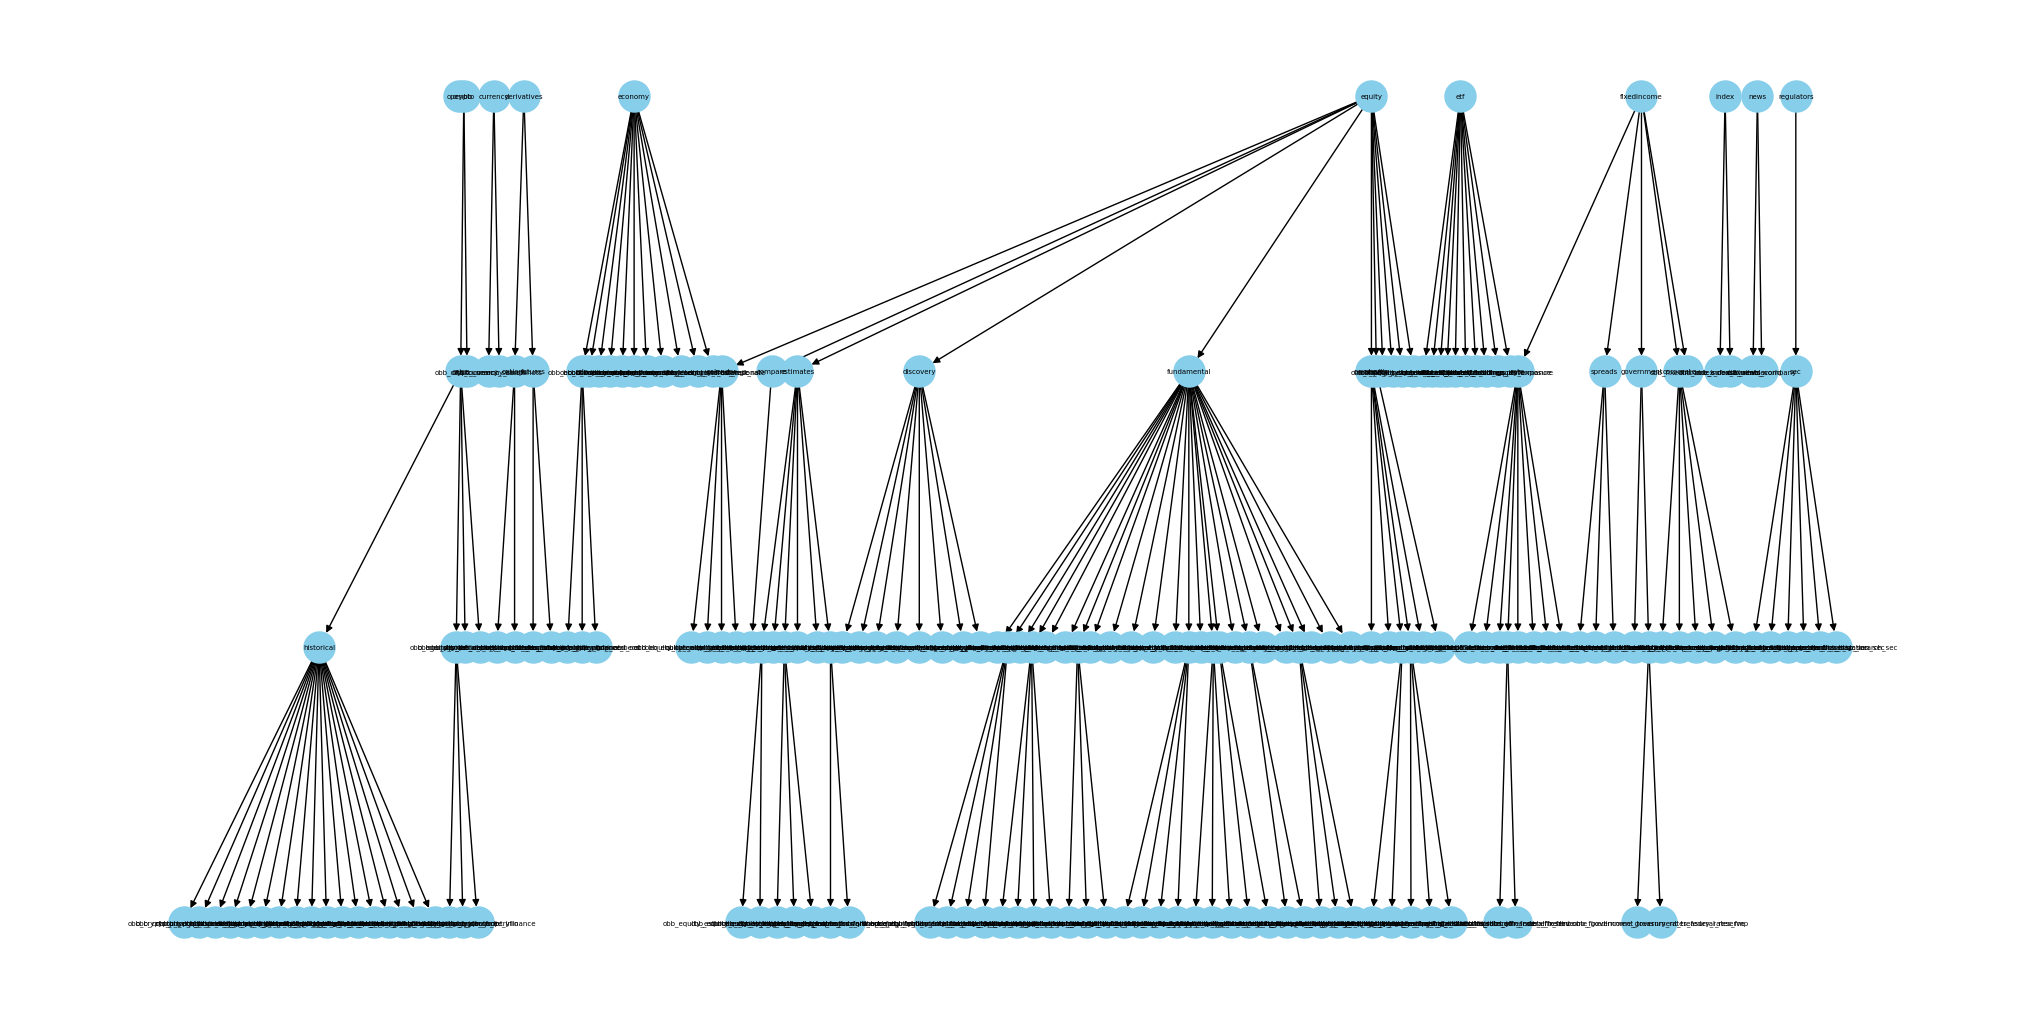

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
pos = graphviz_layout(openbb_graph, prog="dot")
plt.figure(figsize=(20, 10))
nx.draw(openbb_graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, arrows=True)
# plt.title(f"{router.capitalize()}")
plt.show()

In [5]:
openbb_graph['openbb'].items()

ItemsView(AtlasView({}))

In [6]:
openbb_graph.nodes['price']

{'type': 'second_level_node',
 'trail': 'crypto',
 'description': 'Historical Index Levels.'}

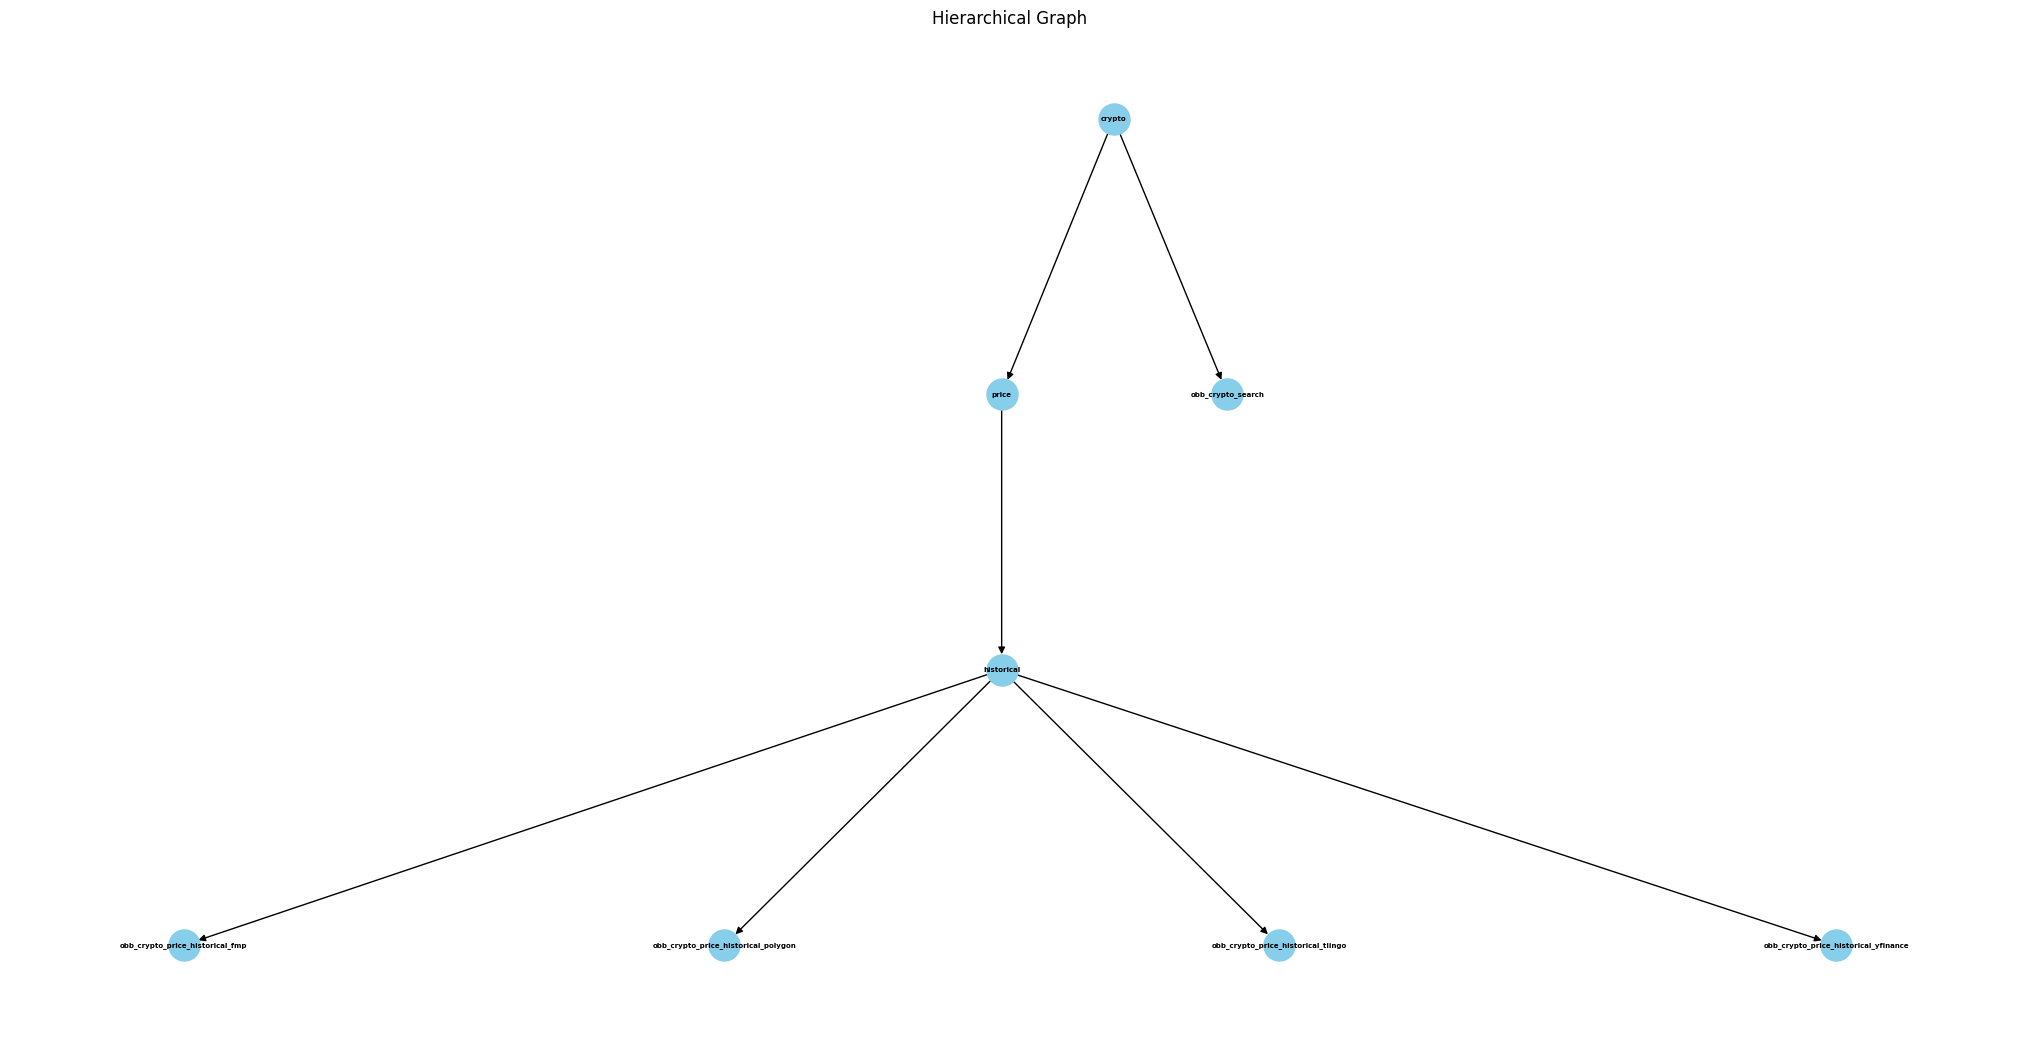

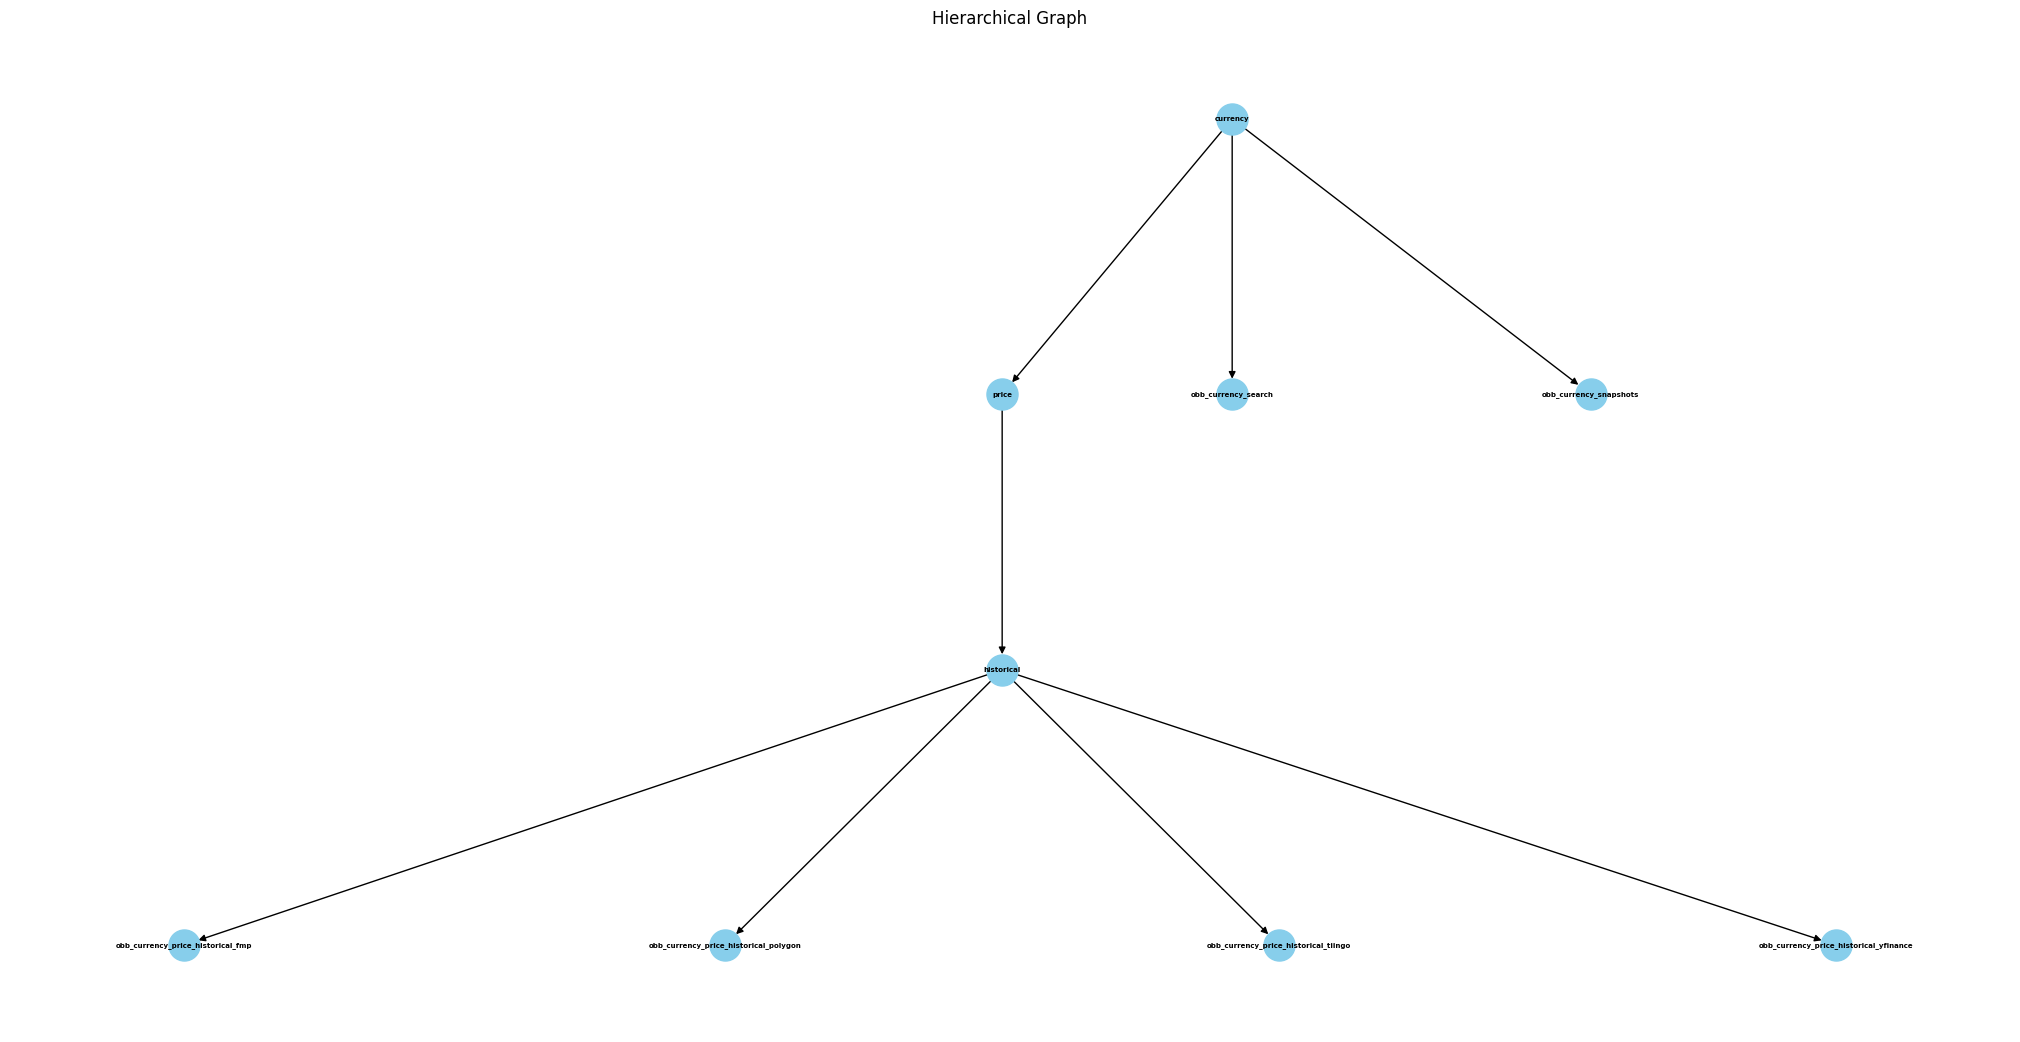

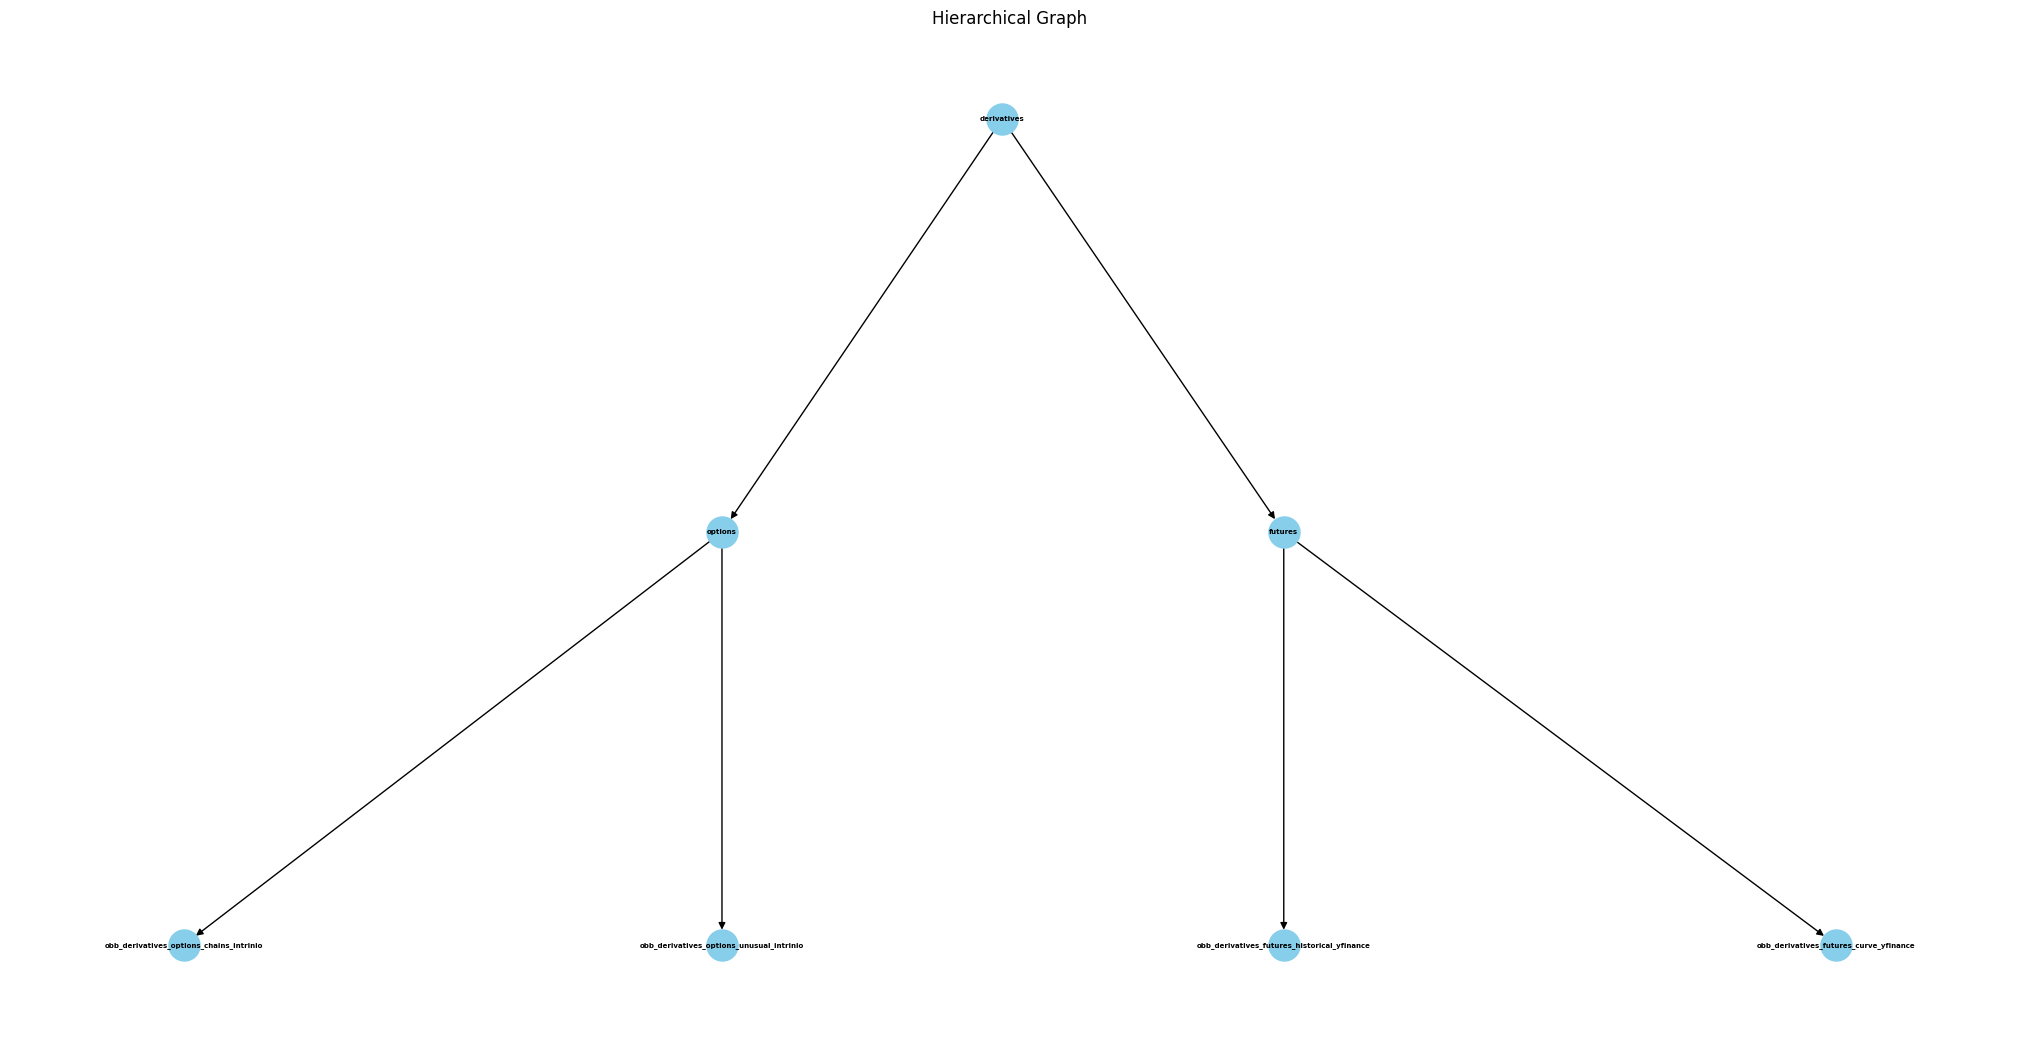

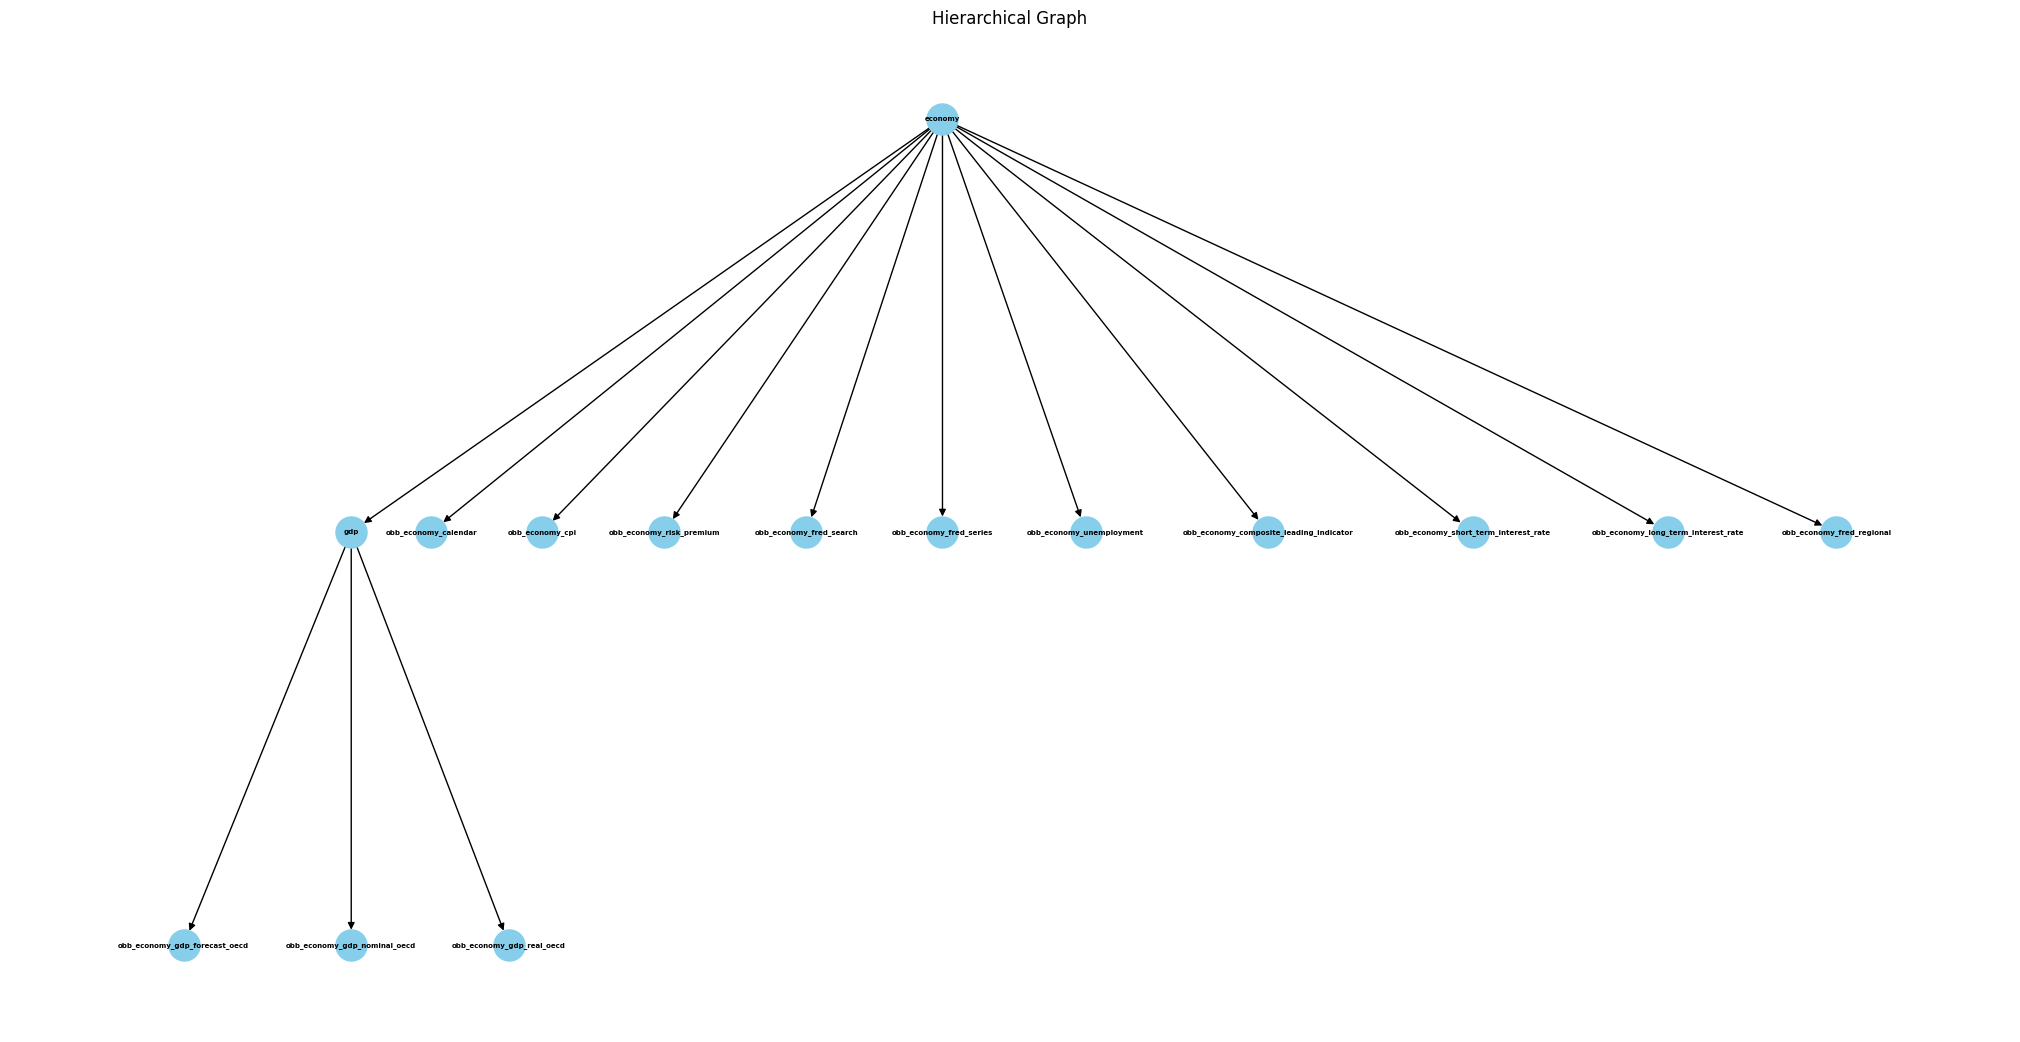

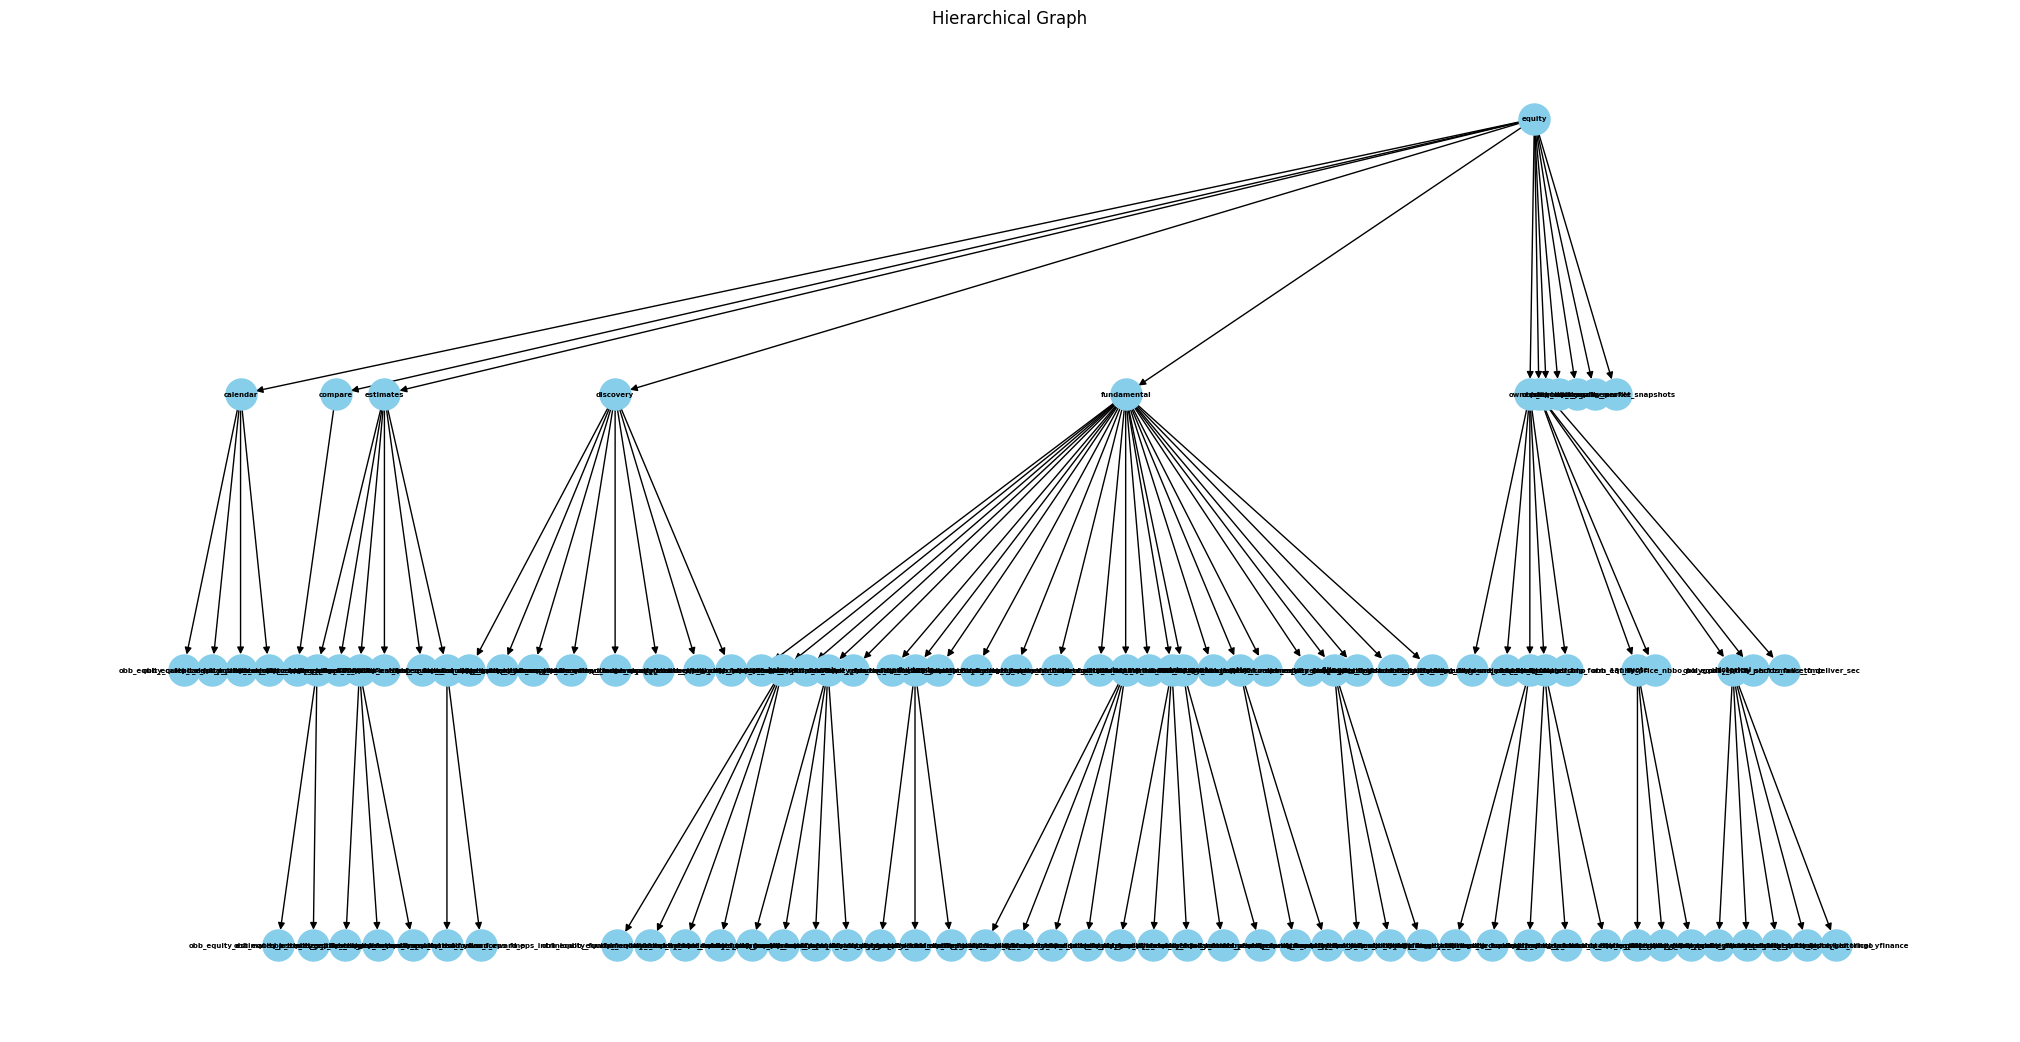

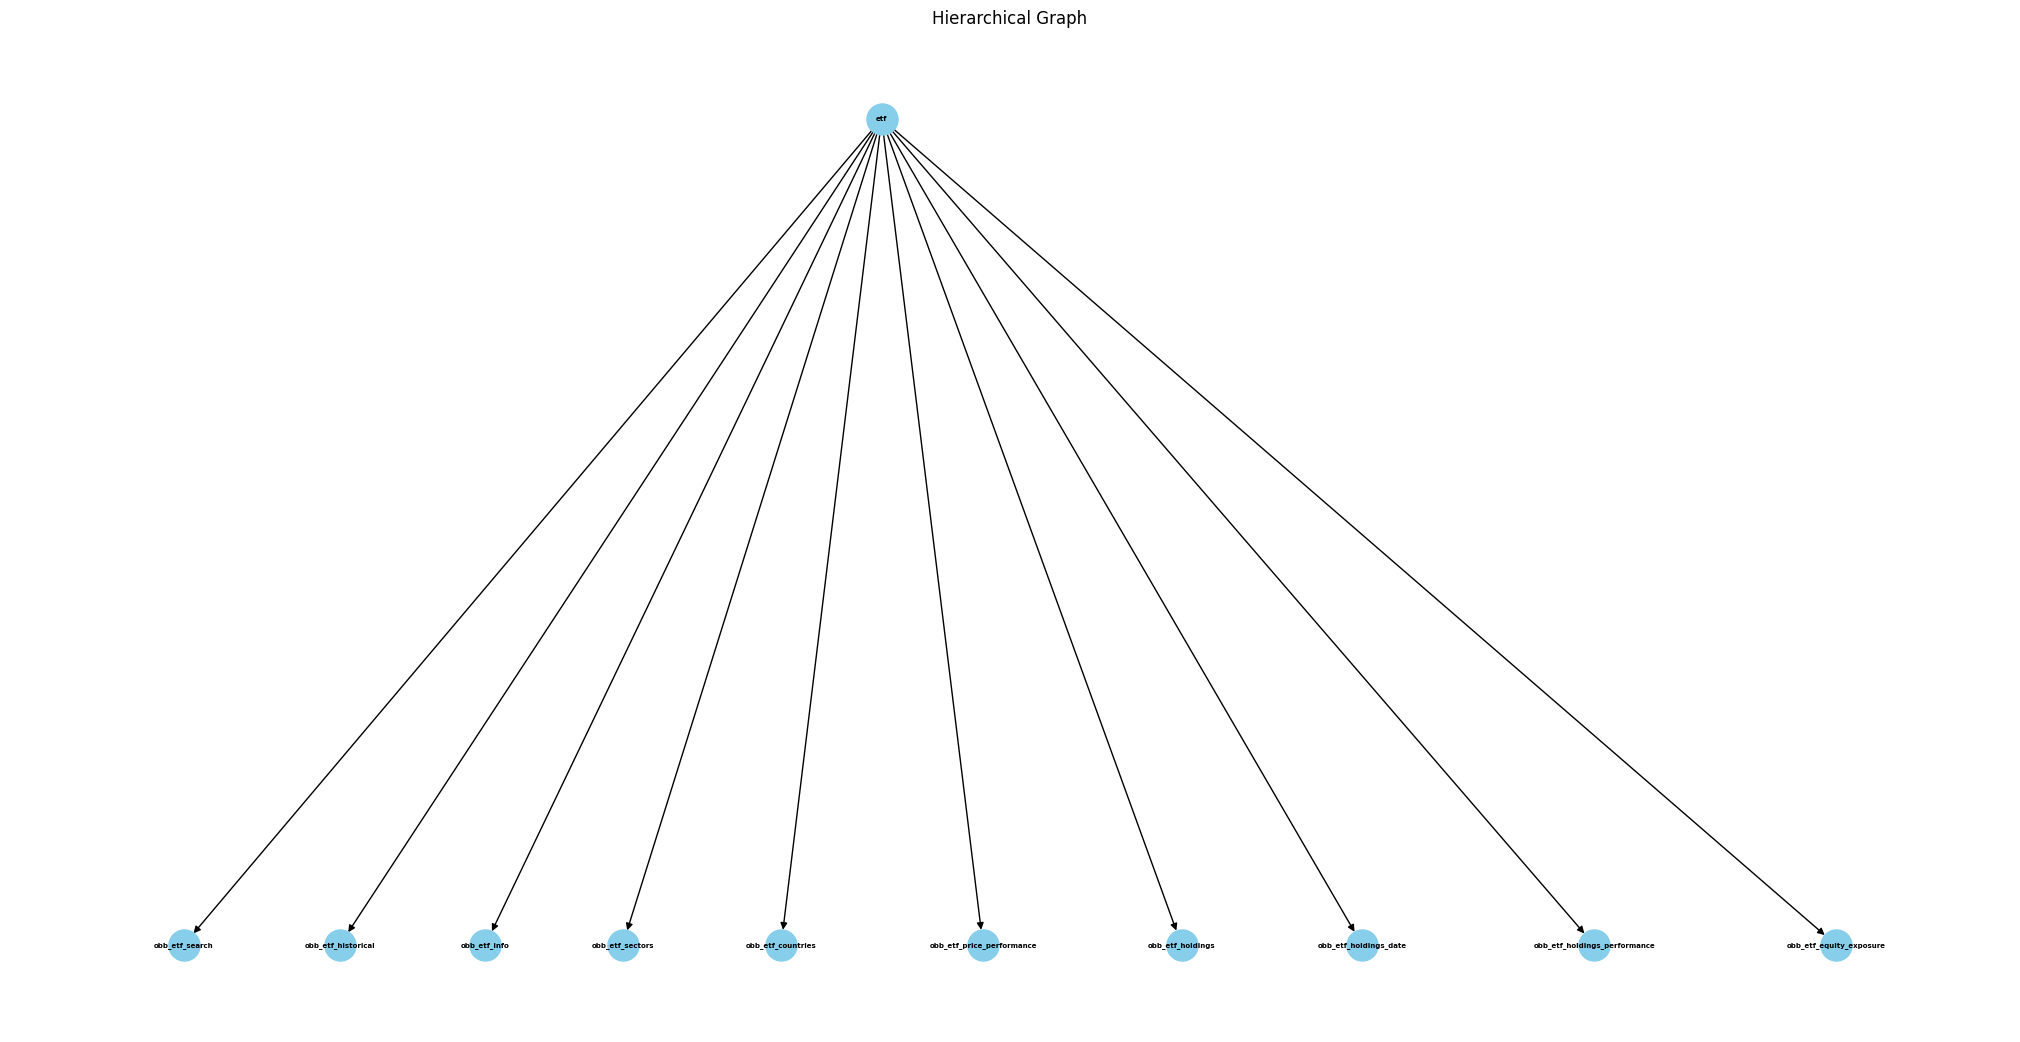

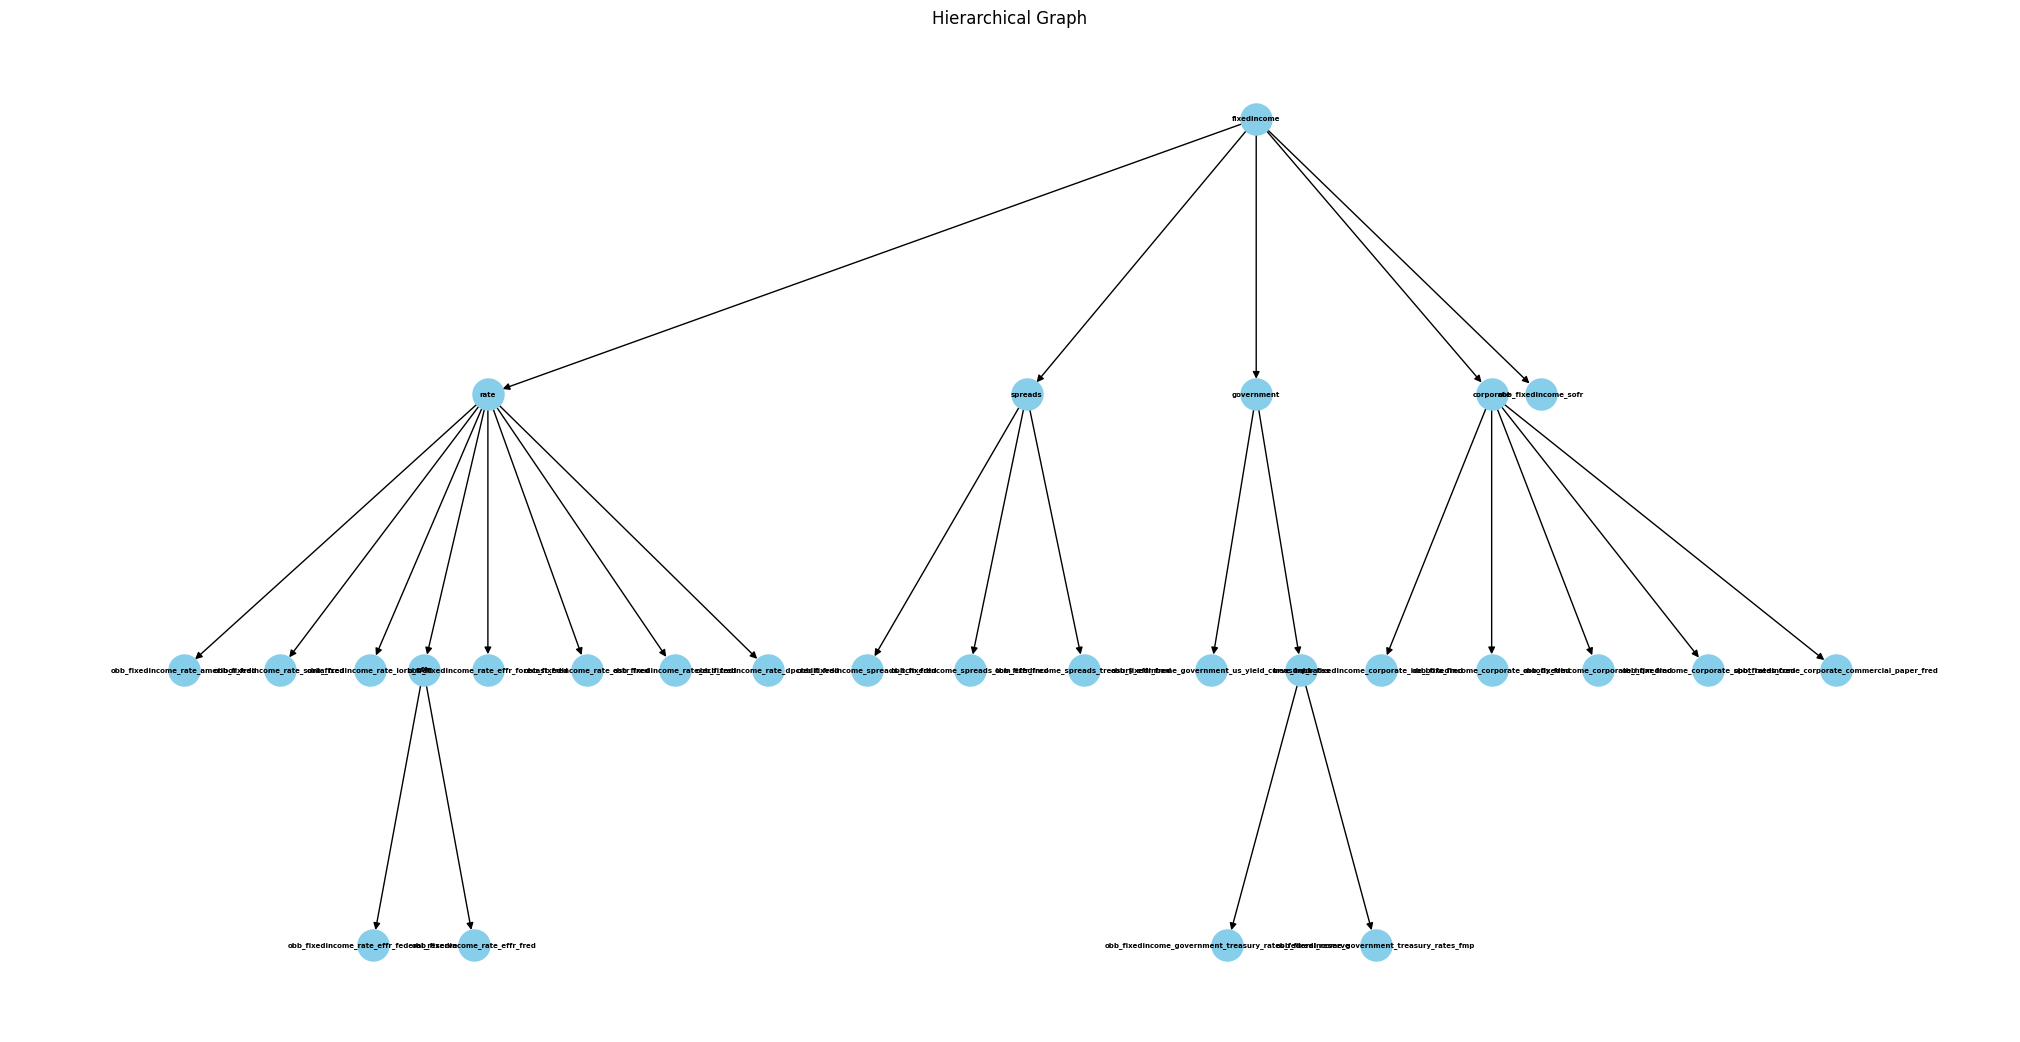

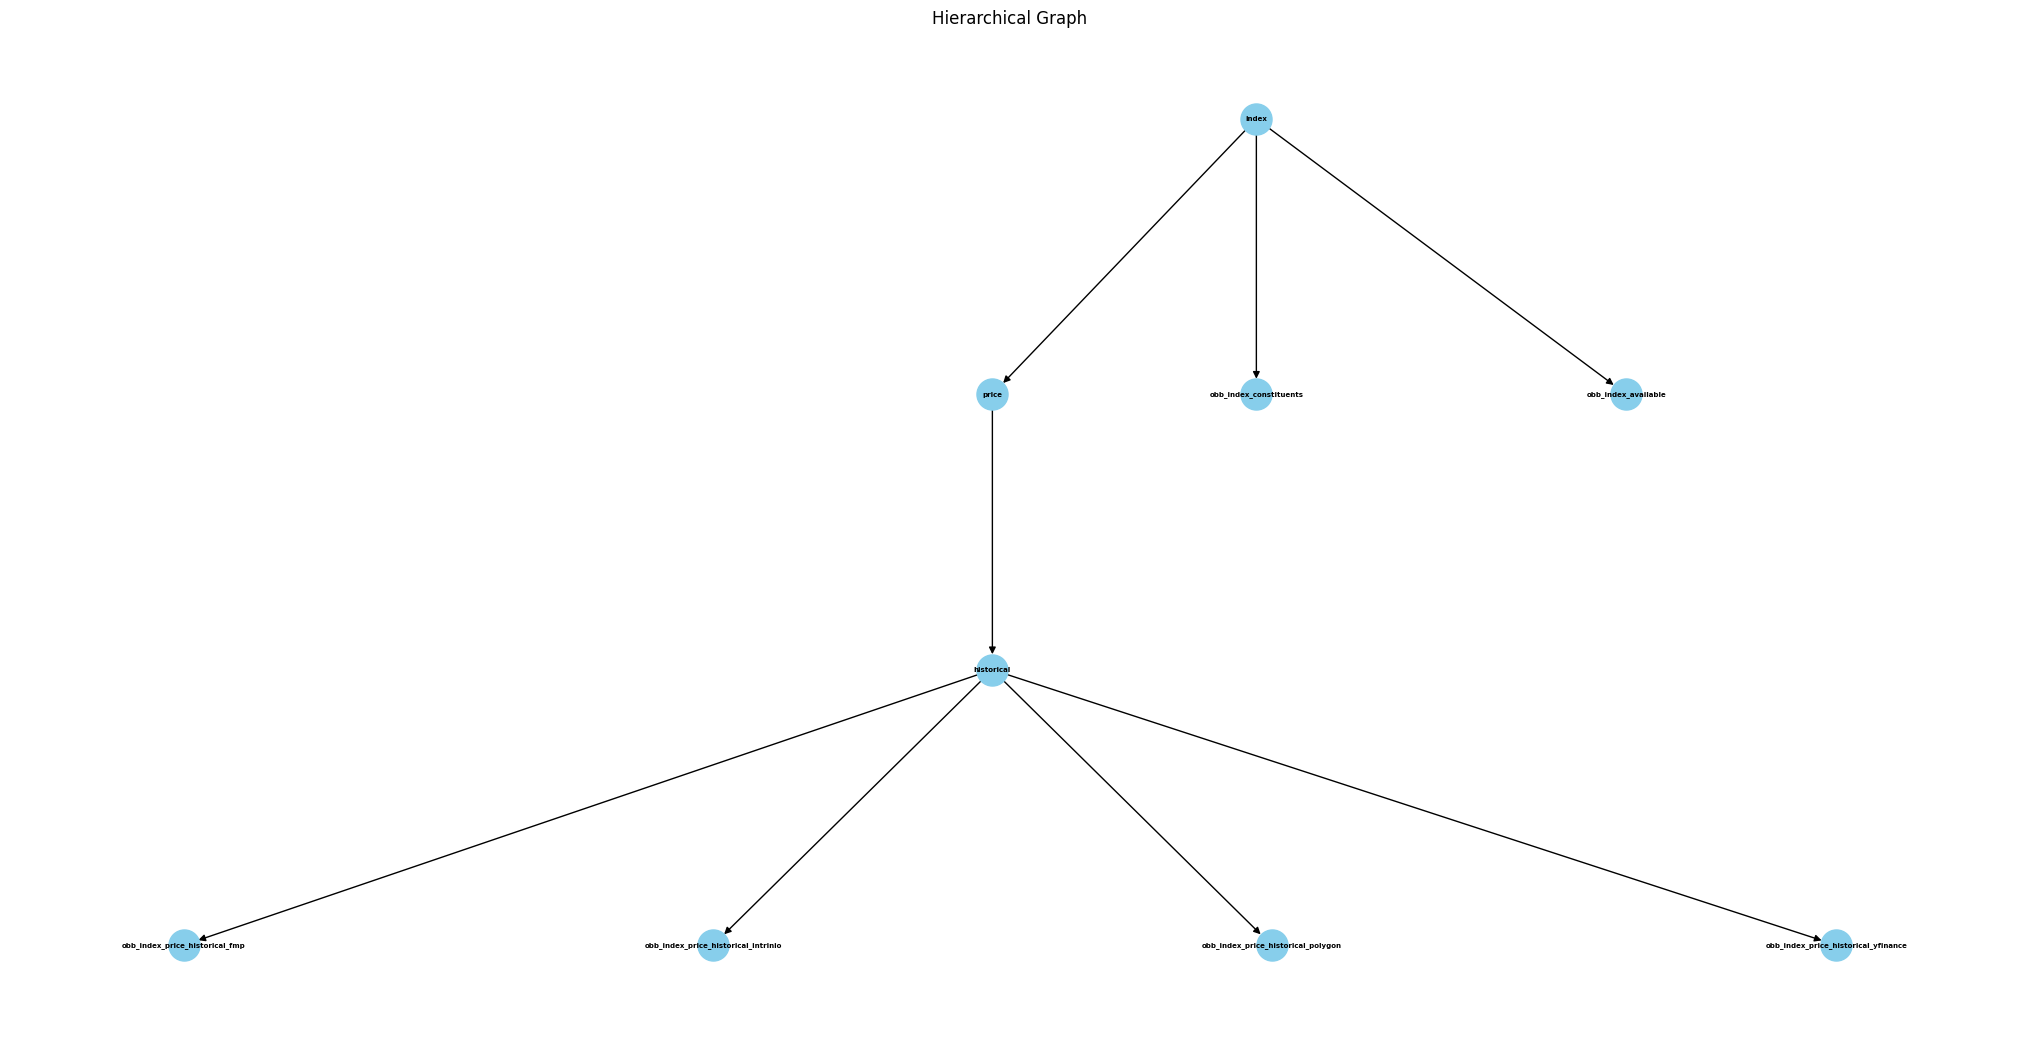

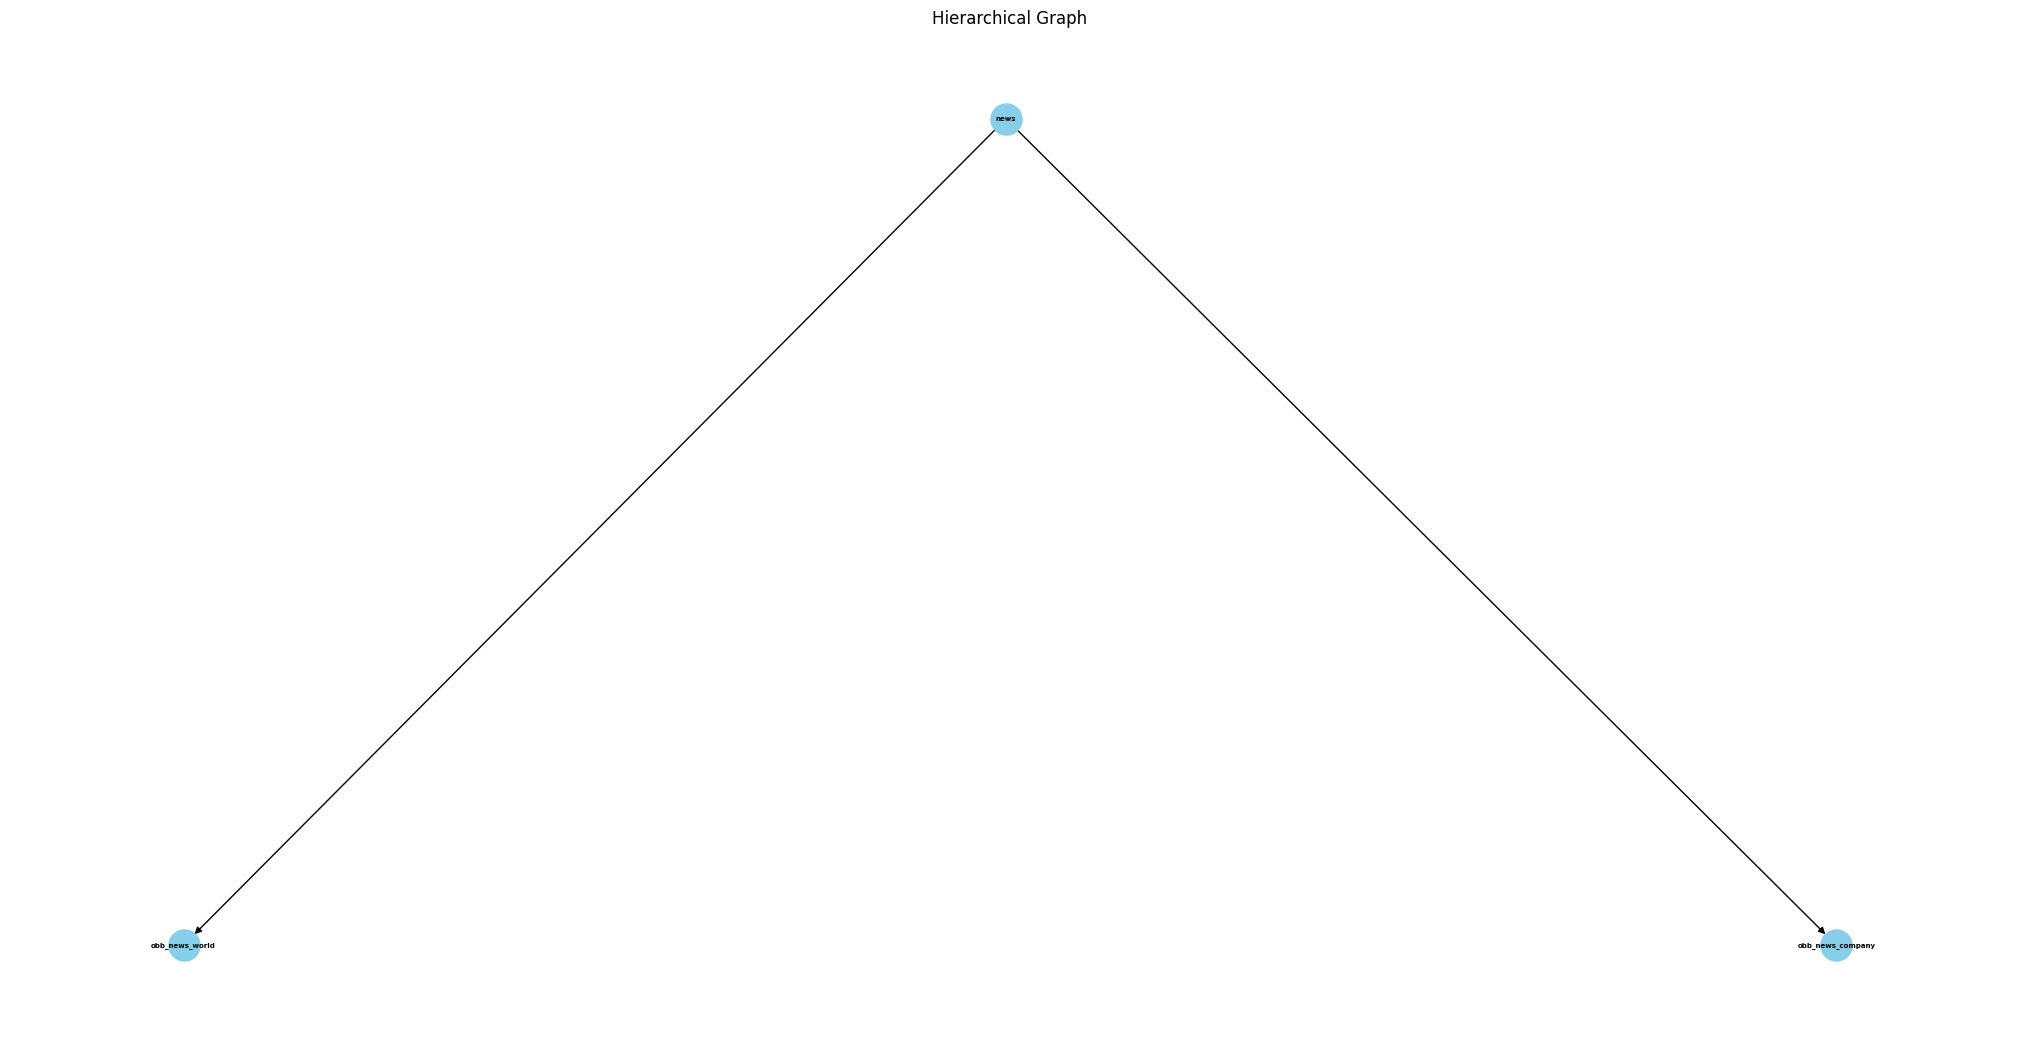

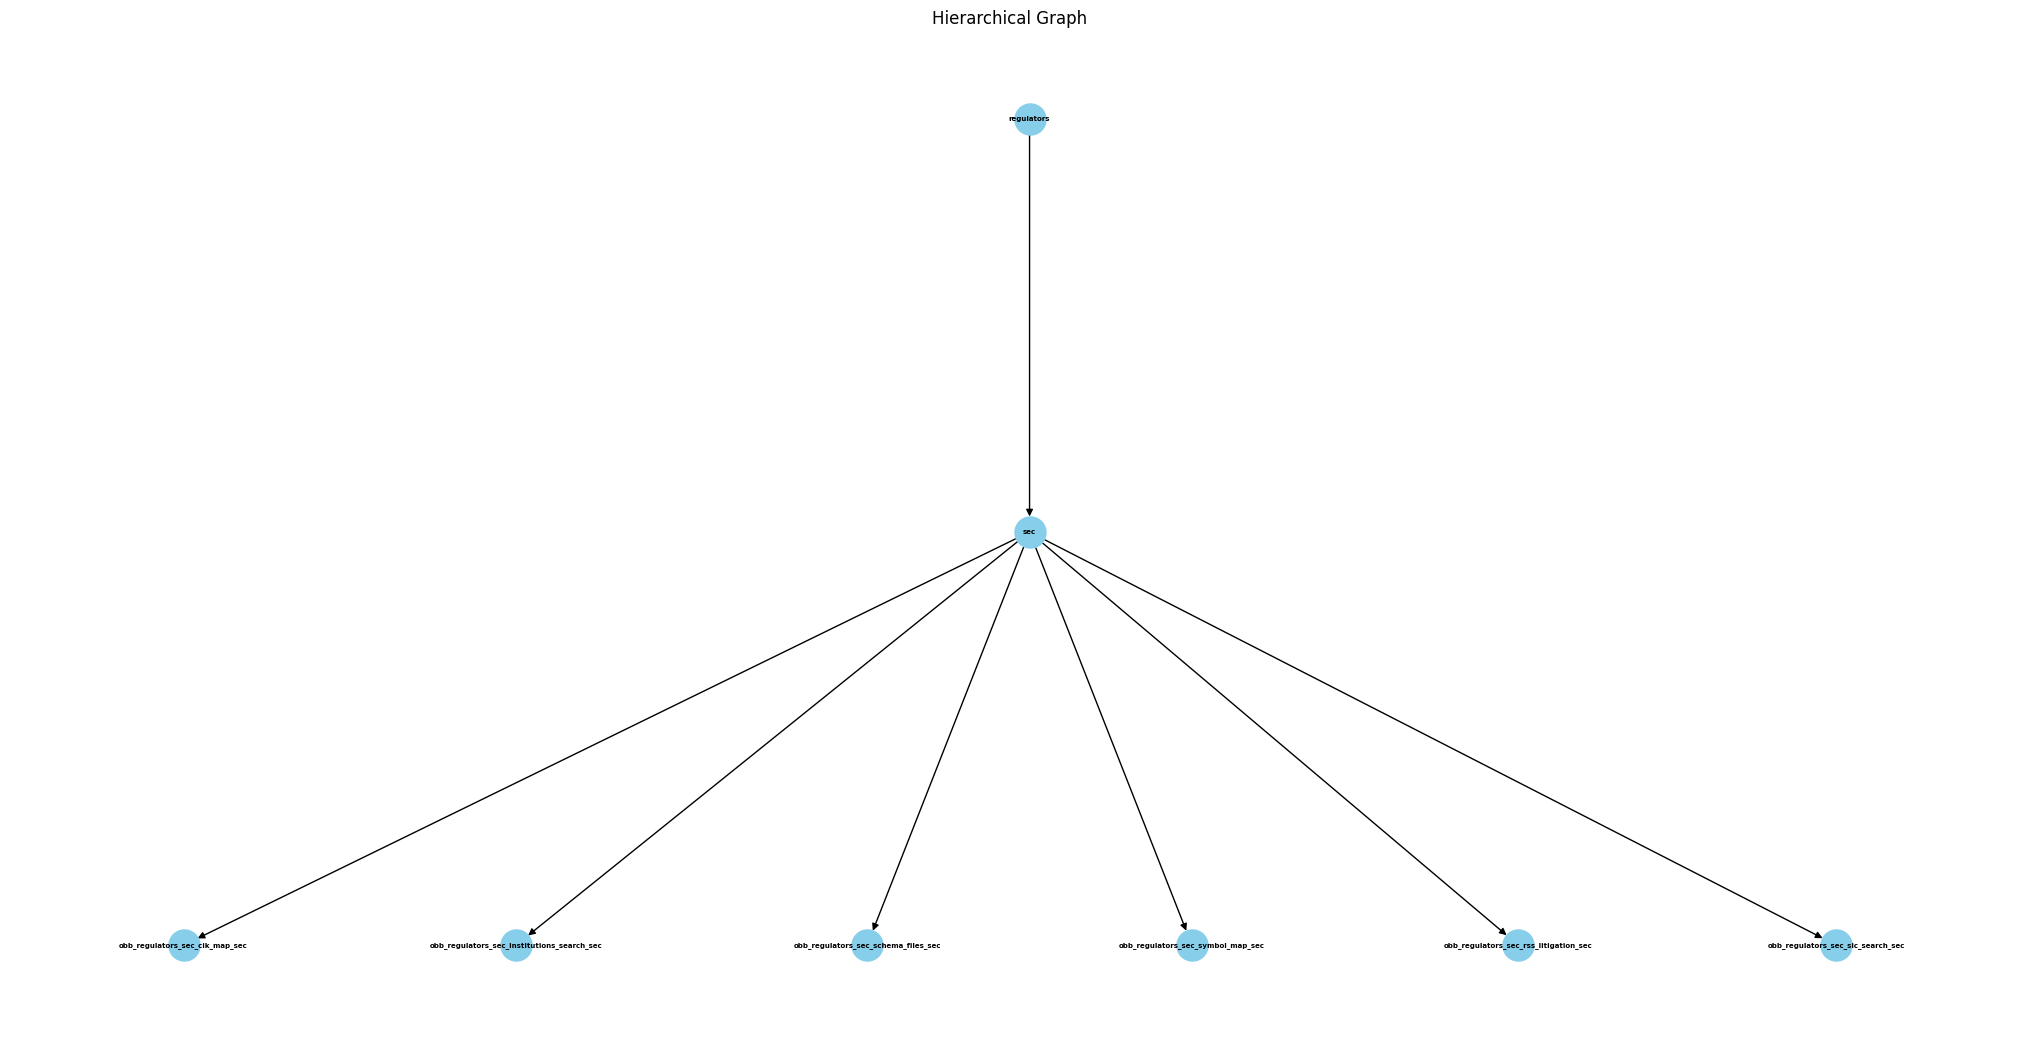

In [7]:
for router in routers_names:
    graph = router_names_graph[router]
    pos = graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(20, 10))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, font_weight="bold", arrows=True)
    plt.title("Hierarchical Graph")
    plt.show()

In [8]:
routers_names

['crypto',
 'currency',
 'derivatives',
 'economy',
 'equity',
 'etf',
 'fixedincome',
 'index',
 'news',
 'regulators']

In [181]:
G = router_names_graph['crypto']

In [182]:
for node, attributes in G.nodes(data=True):
    print("Node:", node)
    print("Attributes:", attributes)

Node: crypto
Attributes: {'type': 'first_level_node', 'description': 'Cryptocurrency market data.'}
Node: price
Attributes: {'type': 'second_level_node', 'trail': 'crypto', 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.'}
Node: historical
Attributes: {'type': 'standard_function', 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.', 'function_call': {'name': 'obb_crypto_price_historical', 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.', 'parameters': {'type': 'object', 'properties': {'symbol': {'type': 'string', 'description': 'Symbol to get data for. Can use CURR1-CURR2 or CURR1CURR2 format. Multiple items allowed for provider(s): fmp, polygon, tiingo, yfinance.', 'default': ''}, 'start_date': {'type': 'string', 'description': 'Start date of the data, in YYYY-MM-DD format.', 'default': None}, 'end_date': {'type': 'string', 'description': 'End date of the data, in YYYY-

In [217]:
import ast
docs = []
metadata = []
non_embed_docs =[]
non_embed_metadata = []
for router_name,router_graph in router_names_graph.items():
    for node,attributes in router_graph.nodes(data=True):
        if attributes['type'] in ["first_level_node", "second_level_node", 'second_level_provider_function',"standard_function"]:
            docs.append(attributes['description'])
            attributes.update({"node_name":node})
            if "function_call" in attributes:
                # print(ast.literal_eval(attributes['function_call'])['name'].rpartit)
                if not isinstance(attributes['function_call'],str):
                    attributes.update({"provider":attributes['function_call']['name'].rpartition('_')[-1]})
                else:
                    attributes.update({"provider":ast.literal_eval(attributes['function_call'])['name'].rpartition('_')[-1]})
            for key,value in attributes.items():
                if isinstance(value,dict):
                    attributes[key] = str(value)
                else:
                    pass
            metadata.append(attributes)
        else:
            if 'description' in attributes:
                non_embed_docs.append(attributes['description'])
            else:
                non_embed_docs.append("empty")
            attributes.update({"node_name":node})
            if "function_call" in attributes:
                # print(ast.literal_eval(attributes['function_call'])['name'].rpartit)
                attributes.update({"provider":attributes['function_call']['name'].rpartition('_')[-1]})
            for key,value in attributes.items():
                if isinstance(value,dict):
                    attributes[key] = str(value)
                else:
                    pass
            non_embed_metadata.append(attributes)

In [218]:
len(docs),len(metadata)

(81, 81)

In [186]:
metadata[20]

{'type': 'second_level_provider_function',
 'description': 'Use the composite leading indicator (CLI).\n\nIt is designed to provide early signals of turning points\nin business cycles showing fluctuation of the economic activity around its long term potential level.\n\nCLIs show short-term economic movements in qualitative rather than quantitative terms.',
 'function_call': "{'name': 'obb_economy_composite_leading_indicator_oecd', 'description': 'Use the composite leading indicator (CLI).\\n\\nIt is designed to provide early signals of turning points\\nin business cycles showing fluctuation of the economic activity around its long term potential level.\\n\\nCLIs show short-term economic movements in qualitative rather than quantitative terms.', 'parameters': {'type': 'object', 'properties': {}, 'required': ['provider']}}",
 'trail': 'economy-->obb_economy_composite_leading_indicator',
 'node_name': 'obb_economy_composite_leading_indicator',
 'provider': 'oecd'}

In [48]:
# for  m in metadata:
#     if ast.literal_eval(m)['type'] == 'first_level_node':
#         print(m)
        # break

In [211]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
import os
from chromadb.utils.batch_utils import create_batches

from dotenv import load_dotenv
load_dotenv(override=True)
emb_fn = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ['OPENAI_API_KEY'],
                model_name="text-embedding-3-small")

client = chromadb.PersistentClient(path="OpenBB")
if client.get_collection(name="obb"):
    client.delete_collection(name="obb")

openbb_collection = client.create_collection(name="obb",embedding_function=emb_fn)
openbb_provider_collection = client.create_collection(name="obb_providers",embedding_function=emb_fn)
openbb_ids = [f"id{i}" for i in range(len(docs))]
batches = create_batches(api=client,ids=openbb_ids, documents=docs, metadatas=metadata)
for batch in batches:
    openbb_collection.add(ids=batch[0],
                documents=batch[3],
                metadatas=batch[2])

In [219]:
# openbb_collection = client.get_collection(name="obb",embedding_function=None)
openbb_provider_collection = client.get_or_create_collection(name="obb_providers",embedding_function=emb_fn)

openbb_provider_collection.add(
    ids = [f"non_id{i}" for i in range(len(non_embed_docs))],
    documents=non_embed_docs,
    metadatas=non_embed_metadata
)

In [100]:
client = chromadb.PersistentClient(path="OpenBB")
openbb_collection = client.get_collection(name="obb",embedding_function=emb_fn)

In [101]:
openbb_collection

Collection(name=obb)

In [102]:
import dspy

first_level = dspy.OpenAI(model='gpt-3.5-turbo',max_tokens=20)
second_level = dspy.OpenAI(model='gpt-3.5-turbo',max_tokens=50)
function_calling_llm = dspy.OpenAI(model='gpt-3.5-turbo-1106',max_tokens=256)

In [220]:
class FirstSecondLevel(dspy.Signature):
    """You are given a list of keys and values separated by semicolon. 
    Based on the query, you have to output the key that is most relevant to the question.
    Don't include any other information
    """
    query = dspy.InputField(prefix="Query which you need to classify: ",format=str)
    keys_values = dspy.InputField(prefix="Keys and Values: ",format=str)
    output = dspy.OutputField(prefix="Relevant Key: ",format=str)

# class SecondLevel(dspy.Signature):
dspy.settings.configure(lm=second_level)

class OpenBBAgent(dspy.Module):
    """OpenBB Agent for function calling"""
    def __init__(self,collection):
        """Init function for OpenBB agent
        """
        super(OpenBBAgent,self).__init__()
        self.collection = collection
        get_first_level = self.collection.get(where={"type":"first_level_node"})
        self.first_level = ""
        for first_level_metadata in get_first_level['metadatas']:
            
            self.first_level += f"{first_level_metadata['node_name']}: {first_level_metadata['description']}\n"
        self.firstSecondLevel = dspy.ChainOfThought(FirstSecondLevel)
        self.second_level_where_clause = {
                        "$or": [
                            {
                                "type": {
                                    "$eq": "second_level_node"
                                }
                            },
                            {
                                "type": {
                                    "$eq": "second_level_provider_function"
                                }
                            }
                        ]
                    }
        
    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)
    def forward(self,query:str):
        question_emb = emb_fn([query])[0]
        first_level_answer = self.firstSecondLevel(query=query,keys_values=self.first_level).output
        # print(first_level_answer)

        second_level = self.collection.query(
            query_embeddings = question_emb,
            where = {
                "$and":[
                    {
                        "trail": {
                            "$eq": first_level_answer
                        }
                    },
                    self.second_level_where_clause
                ]
            },
            n_results = 5
        )
        print(second_level)
        second_level_str = ""
        for second_level_metadata in second_level['metadatas'][0]:
            second_level_data = second_level_metadata['description'].replace('\n\n', '').replace('\n', '')
            second_level_str += f"{second_level_metadata['node_name']}: {second_level_data}\n"
        
        second_level_answer = self.firstSecondLevel(query=query,keys_values=second_level_str).output
        for second_level_metadata in second_level['metadatas'][0]:
            if second_level_metadata['node_name'] == second_level_answer and second_level_metadata['type'] == "second_level_node":
                trail = first_level_answer +"-->"+second_level_metadata['node_name']
                # Get the standard function
                third_level = self.collection.query(
                    query_embeddings = question_emb,
                    where = {
                        "$and": [
                            {
                                "type": {
                                    "$eq": "standard_function"
                                }
                            },
                            {
                                "trail": {
                                    "$eq": trail
                                }
                            }
                        ]
                    },
                    n_results = 5
                )
                print(trail)
                # third_level = self.collection.query(
                #     query_embeddings = question_emb,
                #     where = {
                #         "trail": {
                #             "$eq": trail
                #         }
                #     },
                #     n_results = 1
                # )
                print(third_level)
                # for third_level_metadata in third_level['metadatas'][0]:
                    
            elif second_level_metadata['node_name'] == second_level_answer and second_level_metadata['type'] == "second_level_provider_function":
                functions = ast.literal_eval(second_level_metadata['function_call'])
                
        
openbb_agent = OpenBBAgent(openbb_collection)
openbb_agent("What is the price of Bitcoin?")

{'ids': [['id1']], 'distances': [[1.3289335734520453]], 'metadatas': [[{'description': 'Get historical price data for cryptocurrency pair(s) within a provider.', 'node_name': 'price', 'trail': 'crypto', 'type': 'second_level_node'}]], 'embeddings': None, 'documents': [['Get historical price data for cryptocurrency pair(s) within a provider.']], 'uris': None, 'data': None}
crypto-->price
{'ids': [[]], 'distances': [[]], 'metadatas': [[]], 'embeddings': None, 'documents': [[]], 'uris': None, 'data': None}


In [163]:
get_first_level = openbb_collection.get(
    where = {
                        "$and": [
                            {
                                "type": {
                                    "$eq": "standard_function"
                                }
                            },
                            {
                                "trail": {
                                    "$eq": "crypto-->price"
                                }
                            }
                        ]
                    },
)
print(get_first_level)
first_level = ""
for first_level_metadata in get_first_level['metadatas']:
    print(first_level_metadata)
    # data = first_level_metadata['description'].replace('\n\n', '').replace('\n', '')
    # first_level += f"{first_level_metadata['node_name']}: {data}\n"

{'ids': [], 'embeddings': None, 'metadatas': [], 'documents': [], 'uris': None, 'data': None}


In [167]:
for m in metadata:
    print(m)

crypto
crypto-->obb_crypto_search
currency
currency-->obb_currency_search
currency-->obb_currency_snapshots
derivatives
derivatives
economy
economy-->obb_economy_calendar
economy-->obb_economy_cpi
economy-->obb_economy_risk_premium
economy-->obb_economy_fred_search
economy-->obb_economy_fred_series
economy-->obb_economy_unemployment
economy-->obb_economy_composite_leading_indicator
economy-->obb_economy_short_term_interest_rate
economy-->obb_economy_long_term_interest_rate
economy-->obb_economy_fred_regional
equity
equity
equity
equity
equity
equity
equity
equity
equity-->obb_equity_search
equity-->obb_equity_screener
equity-->obb_equity_profile
equity-->obb_equity_market_snapshots
etf-->obb_etf_search
etf-->obb_etf_historical
etf-->obb_etf_info
etf-->obb_etf_sectors
etf-->obb_etf_countries
etf-->obb_etf_price_performance
etf-->obb_etf_holdings
etf-->obb_etf_holdings_date
etf-->obb_etf_holdings_performance
etf-->obb_etf_equity_exposure
fixedincome
fixedincome
fixedincome
fixedincome
fi

In [137]:
first_level_metadata

{'description': 'Snapshots of currency exchange rates from an indirect or direct perspective of a base currency.',
 'function_call': "{'name': 'obb_currency_snapshots_fmp', 'description': 'Snapshots of currency exchange rates from an indirect or direct perspective of a base currency.', 'parameters': {'type': 'object', 'properties': {}, 'required': ['provider']}}",
 'node_name': 'obb_currency_snapshots',
 'provider': 'fmp',
 'trail': 'currency-->obb_currency_snapshots',
 'type': 'second_level_provider_function'}

In [131]:
get_first_level['metadatas']

[{'description': 'Get the upcoming, or historical, economic calendar of global events. Get it from provider fmp',
  'function_call': '{\'name\': \'obb_economy_calendar_fmp\', \'description\': \'Get the upcoming, or historical, economic calendar of global events. Get it from provider fmp\', \'parameters\': {\'type\': \'object\', \'properties\': {\'start_date\': {\'type\': \'string\', \'description\': \'Start date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'end_date\': {\'type\': \'string\', \'description\': \'End date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'provider\': {\'description\': "The provider to use for the query, by default None. If None, the provider specified in defaults is selected or \'fmp\' if there is no default.", \'default\': \'fmp\', \'type\': \'string\', \'enum\': [\'fmp\']}}, \'required\': [\'provider\']}}',
  'node_name': 'obb_economy_calendar',
  'provider': 'fmp',
  'trail': 'economy-->obb_economy_calendar',
  'type': 'second_le